# Гипотеза 3: влияние даты релиза на пользовательские рейтинги


**Гипотеза:**
> В последние годы (2020-2025) средние пользовательские рейтинги игр ниже, чем в предыдущем десятилетии  (2010-2019).

**Цель проверки:**
проверить, изменились ли пользовательские оценки (user_score) за последние годы и проследить динамику среднего рейтинга по годам релиза.


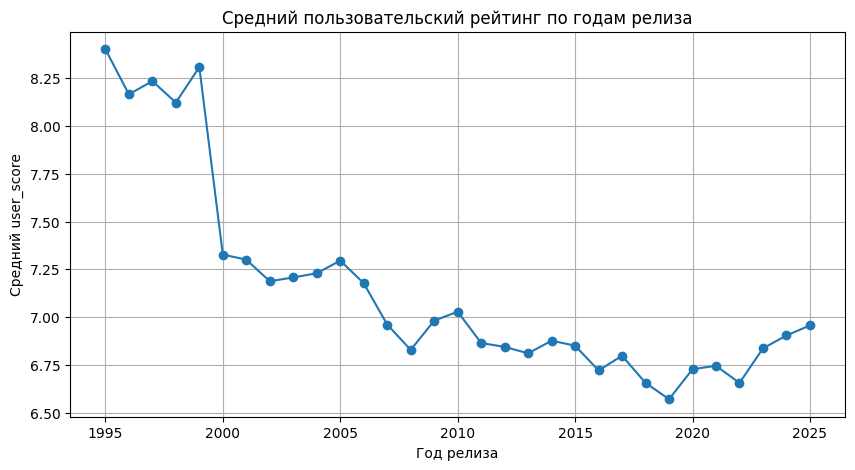

6.798
6.797


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

df = pd.read_csv("merged_clean(last_version).csv", sep=";")

def to_date(series):
  return pd.to_datetime(series, errors="coerce")

date_a = to_date(df.get("release_date"))
date_b = to_date(df.get("released"))
release_dt = date_a.where(~date_a.isna(), date_b)
df["release_year"] = release_dt.dt.year

user_score = pd.to_numeric(df["user_score"], errors="coerce")
df["user_score_clean"] = user_score.where((user_score >= 0) & (user_score <= 10))

yearly = (
    df.dropna(subset=["release_year", "user_score_clean"])
    .groupby("release_year")
    .agg(avg_user_score=("user_score_clean", "mean"))
    .reset_index()
    .sort_values("release_year")
)

plt.figure(figsize=(10, 5))
plt.plot(yearly["release_year"], yearly["avg_user_score"], marker="o")
plt.title("Средний пользовательский рейтинг по годам релиза")
plt.xlabel("Год релиза")
plt.ylabel("Средний user_score")
plt.grid(True)
plt.show()

mask_2010s = df["release_year"].between(2010, 2019)
mask_2020s = df["release_year"].between(2020, 2025)

avg_2010s = df.loc[mask_2010s, "user_score_clean"].mean()
avg_2020s = df.loc[mask_2020s, "user_score_clean"].mean()

print(round(avg_2010s, 3))
print(round(avg_2020s, 3))

Разница 0,0018 - это микроскопическое отличие, заметно меньше любого практического эффекта и визуально не подтверждается трендом на графике.


> Гипотеза о том, что в 2020-2025 пользовательские рейтинги ниже, чем в 2010-2019, не подтверждается. Рейтинги в среднем остались на том же уровне.



# Гипотеза 3.1: влияние времени года на пользовательские оценки игр

**Гипотеза:**


> Предполагается, что в зависимости от времени года, оценки могут меняться.

**Цель проверки:** определить, существует ли зависимость между временем года выхода игры и ее пользовательским рейтингом.



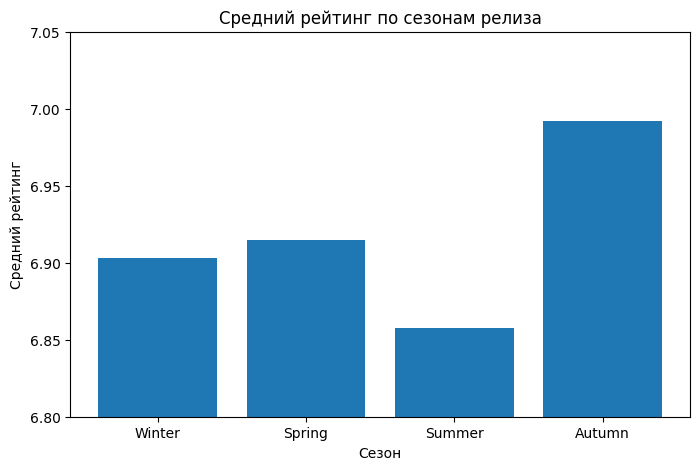

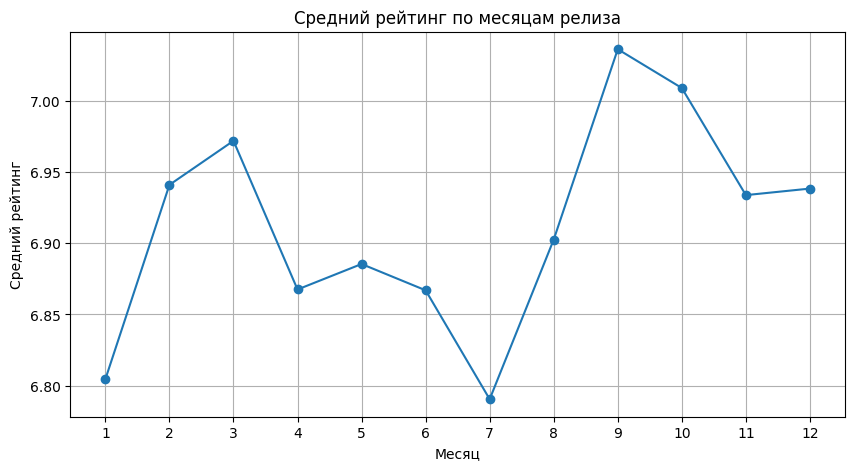

In [5]:
df["month"] = release_dt.dt.month

s = pd.to_numeric(df["user_score"], errors="coerce")
df["user_score_clean"] = s.where(s.between(0, 10, inclusive="both"))

def month_to_season(m):
  if pd.isna(m): return np.nan
  m = int(m)
  if m in (12, 1, 2): return "Winter"
  if m in (3, 4, 5): return "Spring"
  if m in (6, 7, 8): return "Summer"
  if m in (9, 10, 11): return "Autumn"

df["season"] = df["month"].apply(month_to_season)

season_order = ["Winter", "Spring", "Summer", "Autumn"]
seasonal = (
    df.dropna(subset=["season", "user_score_clean"])
    .groupby("season", as_index=False)
    .agg(avg_user_score=("user_score_clean", "mean"),
         n_games=("user_score_clean", "size"))
    .set_index("season").reindex(season_order).reset_index()
)

monthly = (
    df.dropna(subset=["month", "user_score_clean"])
    .groupby("month", as_index=False)
    .agg(avg_user_score=("user_score_clean", "mean"),
         n_games=("user_score_clean", "size"))
    .sort_values("month")
)

plt.figure(figsize=(8,5))
plt.bar(seasonal["season"], seasonal["avg_user_score"])
plt.title("Средний рейтинг по сезонам релиза")
plt.xlabel("Сезон")
plt.ylabel("Средний рейтинг")
plt.ylim(6.8, 7.05)
plt.show()

print()
plt.figure(figsize=(10,5))
plt.plot(monthly["month"], monthly["avg_user_score"], marker="o")
plt.title("Средний рейтинг по месяцам релиза")
plt.xlabel("Месяц")
plt.xticks(range(1, 13))
plt.ylabel("Средний рейтинг")
plt.grid(True)
plt.show()

Осенью средние оценки выше - вероятно, потому что в этот период традиционно выходят крупные игровые релизы (новые части серий, ААА-проекты, подготовка к праздникам), которые получают больше внимания и, как правило, выше качество.

Летом и в начале года - спад. В это время выпускается меньше значимых игр, часто выходят менее масштабные или нишевые проекты, что может снижать средние рейтинги.

Разброс небольшой (0.2 балла), но тенденция осеннего роста прослеживается.



> Гипотеза о зависимости оценок от времени года частично подтверждается - зимой оценки самые высокие, а осенью наблюдается явный пик, что связано скорее с календарем релизов, чем с настроением пользователей.



# Гипотеза 6: влияние активности издателя на стабильность оценок игр

**Гипотеза:**


> Издатели, выпускающие больше игр в течение года, имеют более стабильные (менее вариативные) оценки критиков по сравнению с оценками менее активных издательств.

**Цель проверки:** посмотреть, есть ли связь между количеством выпущенных игр издателем в год и стабильностью оценок.


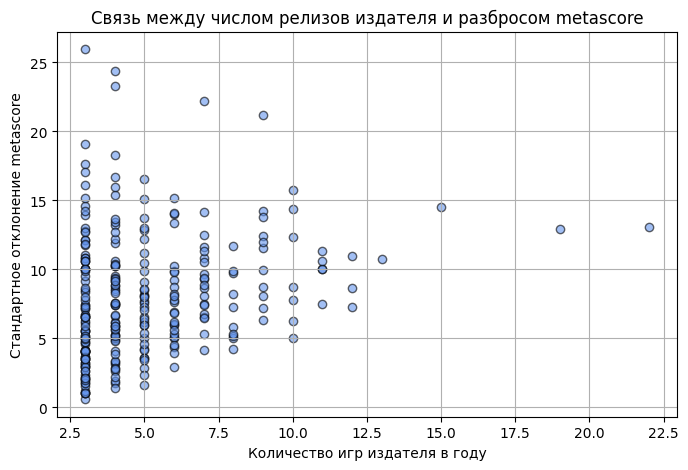

Издатели с 15 и более релизами в год:

           publishers  release_year  games_per_year  metascore_mean  metascore_std
      Electronic Arts        2010.0              22       76.409091      13.029853
      Electronic Arts        2011.0              19       74.842105      12.880921
Ubisoft Entertainment        2010.0              15       69.066667      14.488748


In [6]:
df["metascore_clean"] = pd.to_numeric(df["metascore"], errors="coerce")

df_clean = df.dropna(subset=["publishers", "release_year", "metascore_clean"])

publisher_stats = (
    df_clean.groupby(["publishers", "release_year"])
    .agg(
        games_per_year=("metascore_clean", "count"),
        metascore_std=("metascore_clean", "std"),
        metascore_mean=("metascore_clean", "mean")
    )
    .reset_index()
)

publisher_stats = publisher_stats[publisher_stats["games_per_year"] >= 3]

corr = publisher_stats["games_per_year"].corr(publisher_stats["metascore_std"])

plt.figure(figsize=(8,5))
plt.scatter(
    publisher_stats["games_per_year"], publisher_stats["metascore_std"],
    alpha=0.6, color="cornflowerblue", edgecolors="black"
)
plt.title("Связь между числом релизов издателя и разбросом metascore")
plt.xlabel("Количество игр издателя в году")
plt.ylabel("Стандартное отклонение metascore")
plt.grid(True)
plt.show()

top_publishers = publisher_stats[publisher_stats["games_per_year"] >= 15] \
                    .sort_values(by="games_per_year", ascending=False)

print("Издатели с 15 и более релизами в год:\n")
print(top_publishers[["publishers", "release_year", "games_per_year", "metascore_mean", "metascore_std"]]
      .to_string(index=False))



> Гипотеза частично подтверждается: издатели с большим числом релизов в год действительно имеют чуть менее вариативные оценки, однако корреляция невысокая, и общий разброс metascore остается значительным.



# Гипотеза 7: влияние жанра на вовлеченность пользователей

**Гипотеза:**


> Предполагается, что существуют жанры, вызывающие большую вовлеченность пользователей, выражающуюся в более высоком количестве пользовательских отзывов, по сравнению с другими жанрами.

**Цель проверки:** определить, какие жанры получают больше всего пользовательских отзывов и подтвердить, действительно ли есть жанры, получающие больше пользовательских отзывов.

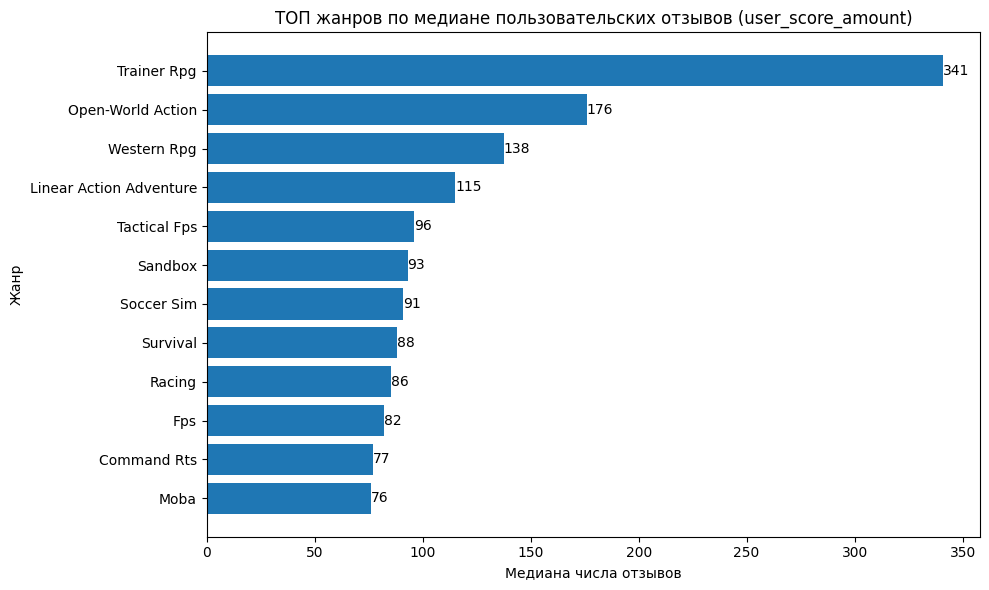

In [7]:
genres = df["genres_parsed"].fillna(df.get("genres_api"))

df["user_score_amount"] = pd.to_numeric(df["user_score_amount"], errors="coerce")
df["user_score_amount"] = df["user_score_amount"].where(df["user_score_amount"] > 0)

tmp = pd.DataFrame({
    "genres_raw": genres,
    "user_score_amount": df["user_score_amount"]
}).dropna(subset=["genres_raw", "user_score_amount"])

tmp["genres_raw"] = tmp["genres_raw"].astype(str)
tmp["genres_list"] = tmp["genres_raw"].str.split(",")
exploded = tmp.explode("genres_list")
exploded["genre"] = exploded["genres_list"].str.strip()

def normalize_genre(g):
    g = g.lower()
    repl = {
        "role-playing": "rpg",
        "role playing": "rpg",
        "rpg": "rpg",
        "jrpg": "rpg",
        "action rpg": "rpg",
        "strategy": "strategy",
        "real-time strategy": "strategy",
        "rts": "strategy",
        "turn-based strategy": "strategy",
        "tactical": "strategy",
    }
    for k, v in repl.items():
        if g == k:
            return v
    return g.title()

exploded["genre_norm"] = exploded["genre"].apply(normalize_genre)

genre_stats = (
    exploded.groupby("genre_norm", as_index=False)
    .agg(
        mean_reviews=("user_score_amount", "mean"),
        median_reviews=("user_score_amount", "median"),
        n_games=("user_score_amount", "size")
    )
    .sort_values("median_reviews", ascending=False)
)

topN = 12
top_genres = genre_stats.head(topN).sort_values("median_reviews", ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(top_genres["genre_norm"], top_genres["median_reviews"])
plt.title("ТОП жанров по медиане пользовательских отзывов (user_score_amount)")
plt.xlabel("Медиана числа отзывов")
plt.ylabel("Жанр")
for y, v in enumerate(top_genres["median_reviews"].values):
    plt.text(v, y, f"{v:.0f}", va="center", ha="left")
plt.tight_layout()
plt.show()

По граффику в топе по медиане действительно присутствуют RPG-жанры: Trainer RPG, Western RPG.



> Гипотеза частично подтверждается - есть жанр, в среднем, получающий больше пользовательских отзывов.



# Гипотеза: влияние мультиплатформенности на оценки критиков

**Гипотеза:**


> Предполагается, что игры, выпущенные на нескольких платформах, получают более высокие оценки критиков, чем эксклюзивы, доступные только на одной платформе.

**Цель проверки:** определить, существует ли различие в оценках между мультиплатформенными играми и экслюзивами.

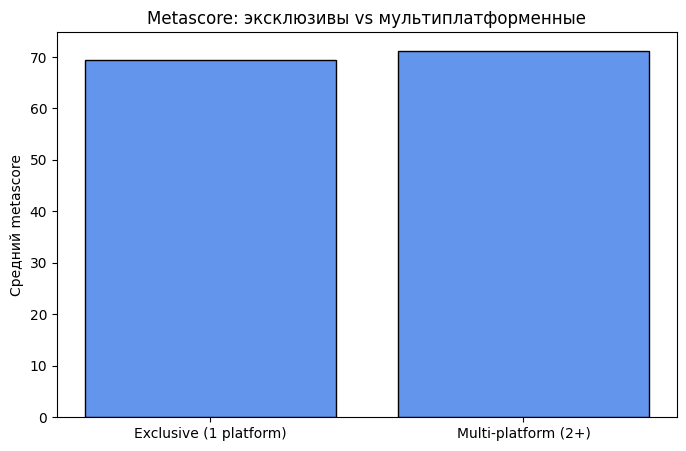

In [8]:
platforms_raw = df["platforms_parsed"].fillna(df.get("platforms_api"))

def count_platforms(s):
    if pd.isna(s):
        return np.nan
    parts = re.split(r"[,/|]", str(s))
    parts = [p.strip() for p in parts if p.strip()]
    return len(set(parts)) if parts else np.nan

df["platform_count"] = platforms_raw.apply(count_platforms)

df["metascore_clean"] = pd.to_numeric(df["metascore"], errors="coerce")
data = df.dropna(subset=["metascore_clean", "platform_count"]).copy()

def to_group(n):
    if n == 1:
        return "Exclusive (1 platform)"
    elif n >= 2:
        return "Multi-platform (2+)"
    else:
        return np.nan

data["platform_group"] = data["platform_count"].apply(to_group)
data = data.dropna(subset=["platform_group"])

summary = (
    data.groupby("platform_group", as_index=False)
        .agg(
            n=("metascore_clean", "size"),
            mean_m=("metascore_clean", "mean"),
            median_m=("metascore_clean", "median"),
            std_m=("metascore_clean", "std")
        )
)
summary["se"] = summary["std_m"] / np.sqrt(summary["n"])
summary["ci95_low"]  = summary["mean_m"] - 1.96 * summary["se"]
summary["ci95_high"] = summary["mean_m"] + 1.96 * summary["se"]


plt.figure(figsize=(8,5))
x = np.arange(len(summary))
plt.bar(x, summary["mean_m"], color="cornflowerblue", edgecolor="black")
plt.xticks(x, summary["platform_group"], rotation=0)
plt.title("Metascore: эксклюзивы vs мультиплатформенные")
plt.ylabel("Средний metascore")
plt.show()


На графике видно, что средние значения metascore у мультиплатформенных и эксклюзивных игр практически одинаковы (разница менее 1 пункта). Это говорит о том, что мультиплатформенность не оказывает заметного влияния на восприятие критиками.